In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
import time

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Custom functions 
def print_gridsearch_results(grid_searcher, unique_params):
    # For a given gridsearcher and the relevant params used in grid_search, print the results of the runs
    # Get the data as a pandas DF
    gsearch_results_df = pd.DataFrame(grid_searcher.cv_results_).copy()
    print("Dataframe has shape: %s" % (str(gsearch_results_df.shape)))
    n_trials_grid_search = gsearch_results_df.shape[0]
    print("Number of trials used in grid search: ", n_trials_grid_search)

    # Rearrange row order so it is easy to skim
    gsearch_results_df.sort_values('rank_test_score', inplace=True)
    # Transform param-text to match up with cv_results_ representation
    param_keys = [f"param_{key}" for key in unique_params]
    return(gsearch_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'mean_fit_time', 'rank_test_score']])



RANDOM_STATE = 123

In [2]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Setup: Importing the Text


In [3]:
data_dir = '../data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

print("Shape of data\n---------------")
print(f"x_train_df shape: {x_train_df.shape} ")
print(f"y_train_df shape: {y_train_df.shape} ")

# Get the text as a list of strings
x_train_text = x_train_df['text'].values
y_train = y_train_df['is_positive_sentiment'].values

Shape of data
---------------
x_train_df shape: (2400, 2) 
y_train_df shape: (2400, 1) 


## Basic comparison of two vectorizers - one with counts and one using tfidf

In [4]:
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit_transform(x_train_text)
x_train_text_count = count_vectorizer.transform(x_train_text).toarray()


In [5]:
len(count_vectorizer.vocabulary_)

4255

In [6]:
tf_vectorizer = TfidfVectorizer(stop_words='english')
tf_vectorizer.fit_transform(x_train_text)
x_train_text_tf = tf_vectorizer.transform(x_train_text).toarray()

In [7]:
len(tf_vectorizer.vocabulary_)

4255

## Train two Random Forests to compare performance

This manual approach to training models is no longer neceesary, as the pipeline enables a much speedier and more effective way of performing this comparison while also tuning hyperparameters.


In [22]:
folds = 7

### Using pipeline to try many tf-idf hyperparameters

In [29]:
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
#     ('clf', RandomForestClassifier(random_state=RANDOM_STATE)),
    ('clf', sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE, C=10.0, max_iter=20))
 ])
tfidf_parameters = {
    'tfidf__min_df': np.arange(1,5),
#     'tfidf__max_df': (0.01, 0.05, 1.0),
#     'tfidf__ngram_range': [(1, 1), (1, 2), (2,2)],
}

tfidf_grid_searcher = GridSearchCV(
    tfidf_pipeline, 
    tfidf_parameters, 
    cv=folds, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tfidf_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 4 candidates, totalling 28 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  28 out of  28 | elapsed:    4.4s finished
/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(C=10.0, max_iter=20,
                                                           penalty='l1',
                                                           random_state=123,
                                                           solver='saga'))]),
             n_jobs=3, param_grid={'tfidf__min_df': array([1, 2, 3, 4])},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [30]:
print_gridsearch_results(tfidf_grid_searcher, list(tfidf_parameters.keys()))

Dataframe has shape: (4, 25)
Number of trials used in grid search:  4


,param_tfidf__min_df,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
0,1,0.986667,0.792854,0.620131,1
1,2,0.969792,0.788694,0.391484,2
2,3,0.935903,0.767466,0.275653,3
3,4,0.907430,0.756632,0.222772,4


In [31]:
print("Best parameters set:")
print(tfidf_grid_searcher.best_estimator_[0])
print(tfidf_grid_searcher.best_params_)
cv_results = tfidf_grid_searcher.cv_results_
cv_results

Best parameters set:
TfidfVectorizer(stop_words='english')
{'tfidf__min_df': 1}


{'mean_fit_time': array([0.62013057, 0.3914844 , 0.27565326, 0.22277246]),
 'std_fit_time': array([0.01168307, 0.01949973, 0.00799187, 0.00701035]),
 'mean_score_time': array([0.01314514, 0.01274674, 0.01205601, 0.01254337]),
 'std_score_time': array([0.00162045, 0.0022694 , 0.00164597, 0.00119278]),
 'param_tfidf__min_df': masked_array(data=[1, 2, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'tfidf__min_df': 1},
  {'tfidf__min_df': 2},
  {'tfidf__min_df': 3},
  {'tfidf__min_df': 4}],
 'split0_test_score': array([0.80173059, 0.78133075, 0.76667687, 0.74921801]),
 'split1_test_score': array([0.79868761, 0.79287366, 0.78418673, 0.76665987]),
 'split2_test_score': array([0.80734054, 0.8248334 , 0.80735754, 0.7869577 ]),
 'split3_test_score': array([0.78136475, 0.76677887, 0.72019924, 0.72601319]),
 'split4_test_score': array([0.76971984, 0.76101591, 0.74058208, 0.73187814]),
 'split5_test_score': array([0.81043452

### Characterize the vocabulary for this optimal vectorizer

In [32]:
best_tfidf_vectorizer = tfidf_grid_searcher.best_estimator_[0]
best_tfidf_vectorizer.fit_transform(x_train_text)
x_train_text_tf_best = best_tfidf_vectorizer.transform(x_train_text).toarray()
len(best_tfidf_vectorizer.vocabulary_)

4255

In [33]:
best_tfidf_vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [42]:

def plot_cv_folds(cv_results, param_name, param_label, folds, log10=False, log2=False):
    _, ax = plt.subplots(1, 1)

    # Get averages
    mean_test_score = cv_results['mean_test_score']
    mean_train_score = cv_results['mean_train_score']

    # Get x_values
    param_values = cv_results[f'param_{param_name}']
    x_values = param_values.data.astype(np.float64)
    if (log10):
        x_values = np.log10(x_values)
    elif (log2):
        x_values = np.log2(x_values)

    ax.plot(x_values, mean_test_score, '-bs', label=f'average test')
    ax.plot(x_values, mean_train_score, '-rs', label=f'average train')

    # Get overall mean_train_score
    for fold in range(folds):
        fold_scores = cv_results[f'split{fold}_test_score']
        ax.plot(x_values, fold_scores, 's', label=f'{fold}-validation set')

    ax.set_title(f"{param_label} Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(param_label, fontsize=16)
    ax.set_ylabel('Balanced Accuracy', fontsize=16)
    ax.legend(loc="best", fontsize=15, bbox_to_anchor=(1, 1))

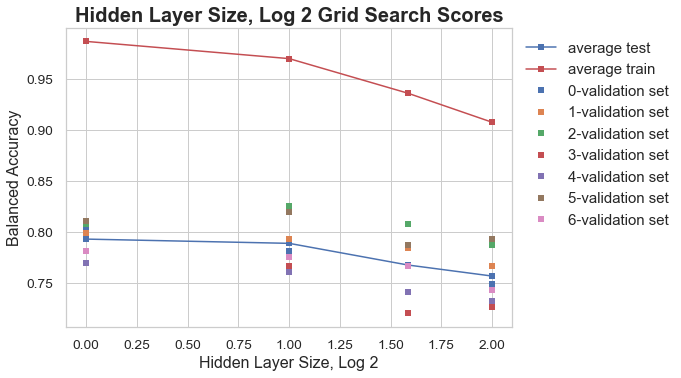

In [43]:
# Plotting the CV results for a gridsearch over one feature

cv_results = tfidf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(tfidf_parameters.keys())[0]
param_label = "Hidden Layer Size, Log 2"

plot_cv_folds(cv_results, param, param_label, folds, log2=True)

# Using pipeline to try many CountVectorizer hyperparameters

In [19]:
count_pipeline = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
#     ('clf', RandomForestClassifier(random_state=RANDOM_STATE)),
    ('clf', sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE, C=10.0, max_iter=20))

 ])
count_parameters = {
    'count__min_df': np.arange(1, 5),
    'count__max_df': (0.05, 0.1, 0.5),
    'count__ngram_range': [(1, 1), (1, 2), (2,2)],
}

count_grid_searcher = GridSearchCV(
    count_pipeline, 
    count_parameters, 
    cv=folds, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
count_grid_searcher.fit(x_train_text, y_train)

print("Best parameters set:")
print(count_grid_searcher.best_estimator_.steps)


Fitting 7 folds for each of 36 candidates, totalling 252 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   14.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   34.6s
[Parallel(n_jobs=3)]: Done 252 out of 252 | elapsed:   58.1s finished


Best parameters set:
[('count', CountVectorizer(max_df=0.1, min_df=2, ngram_range=(1, 2), stop_words='english')), ('clf', LogisticRegression(C=10.0, max_iter=20, penalty='l1', random_state=123,
                   solver='saga'))]


/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [17]:
print_gridsearch_results(count_grid_searcher, list(count_parameters.keys()))

Dataframe has shape: (36, 27)
Number of trials used in grid search:  36


,param_count__min_df,param_count__max_df,param_count__ngram_range,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
28,2,0.5,"(1, 2)",0.992361,0.787487,0.901843,1
16,2,0.1,"(1, 2)",0.992361,0.787487,0.880137,1
27,2,0.5,"(1, 1)",0.992361,0.784983,0.859592,3
15,2,0.1,"(1, 1)",0.992361,0.784983,0.831248,3
24,1,0.5,"(1, 1)",0.997014,0.776243,1.076613,5
12,1,0.1,"(1, 1)",0.997014,0.776243,1.095115,5
25,1,0.5,"(1, 2)",0.997153,0.772493,1.827047,7
13,1,0.1,"(1, 2)",0.997153,0.772493,1.816029,7
31,3,0.5,"(1, 2)",0.980972,0.769149,0.786975,9
19,3,0.1,"(1, 2)",0.980972,0.769149,0.749988,9


In [18]:
best_count_vectorizer = count_grid_searcher.best_estimator_[0]
best_count_vectorizer.fit_transform(x_train_text)
x_train_text_count_best = best_count_vectorizer.transform(x_train_text).toarray()
len(best_count_vectorizer.vocabulary_)

2131

In [51]:
len(x_train_text_count_best[0])

2131

### Archive 

In [58]:
# skf = sklearn.model_selection.StratifiedKFold(n_splits=5)
# count_tf_scores = [[],[]]
# count_tf_train_time = [[],[]]

# for train_index, test_index in skf.split(x_train_text, y_train): 
#     ## Count
#     #
#     count_randforest = RandomForestClassifier(random_state=RANDOM_STATE)
#     # Time the training process
#     start_time_sec = time.time()
#     count_randforest.fit(x_train_text_count[train_index], y_train[train_index])
#     elapsed_time_sec = time.time() - start_time_sec
#     # Get accuracy scores for this split
#     count_y_test_pred = count_randforest.predict(x_train_text_count[test_index])
#     count_balanced_acc = sklearn.metrics.balanced_accuracy_score(
#         y_true=y_train[test_index], 
#         y_pred=count_y_test_pred
#     )
#     print("Performance of the count_vectorized random forest")
#     print(count_balanced_acc)
#     count_tf_scores[0].append(count_balanced_acc)
#     count_tf_train_time[0].append(elapsed_time_sec)
    
#     # TFIDF
#     # 
#     tf_randforest = RandomForestClassifier(random_state=RANDOM_STATE)
#     # Time the training process
#     start_time_sec = time.time()    
#     tf_randforest.fit(x_train_text_tf[train_index], y_train[train_index])
#     elapsed_time_sec = time.time() - start_time_sec
#     # Get accuracy scores for this split
#     tf_y_test_pred=tf_randforest.predict(x_train_text_tf[test_index])
    
#     tf_balanced_acc = sklearn.metrics.balanced_accuracy_score(
#         y_true=y_train[test_index], 
#         y_pred=tf_y_test_pred
#     )
#     print("Performance of the tfidf_vectorized random forest")    
#     print(tf_balanced_acc)
#     count_tf_scores[1].append(tf_balanced_acc)
#     count_tf_train_time[1].append(elapsed_time_sec)
    
# print("Best overall")
# print(f"type:  | score | time ")
# print(f"count: | %5.3f | %4.3f" % (np.mean(count_tf_scores[0]), np.mean(count_tf_train_time[0])))
# print(f"tfidf: | %5.3f | %4.3f" % (np.mean(count_tf_scores[1]), np.mean(count_tf_train_time[1])))
